# Kaggle Store Sales Forecasting

# 1. Imports and Load the Data



In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sktime.forecasting.model_selection import temporal_train_test_split
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

sns.set_palette("Paired")

In [2]:
# create url variable
url1 ='https://drive.google.com/file/d/1TAvsw2pSCm7a9soM1SyG7QWxIuR-mqRE/view?usp=share_link'

# get the data file ID
file_id1 = url1.split('/')[-2]

# create the read url
read_url1='https://drive.google.com/uc?id=' + file_id1

# read the CSV file into a DataFrame
df= pd.read_csv(read_url1).drop('row_id',axis=1)

# set the column type for column with date
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [3]:
# a summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      26298 non-null  datetime64[ns]
 1   country   26298 non-null  object        
 2   store     26298 non-null  object        
 3   product   26298 non-null  object        
 4   num_sold  26298 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.0+ MB


In [4]:
df.head()

,date,country,store,product,num_sold
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


# 2. Sales Trends

## 2.1. Sales by Product, Store and Country

In [5]:
# creation of aggregated sales totals
agg_df = df.groupby(['country','store', 'product'])[['num_sold']].sum()
agg_df = agg_df.reset_index(drop=False).sort_values(by=['num_sold'],
  ascending=False).reset_index(drop=True)

agg_df

,country,store,product,num_sold
0,Norway,KaggleRama,Kaggle Hat,1514119
1,Sweden,KaggleRama,Kaggle Hat,1068652
2,Finland,KaggleRama,Kaggle Hat,918862
3,Norway,KaggleMart,Kaggle Hat,868777
4,Norway,KaggleRama,Kaggle Mug,853659
5,Sweden,KaggleMart,Kaggle Hat,612472
6,Sweden,KaggleRama,Kaggle Mug,600870
7,Finland,KaggleMart,Kaggle Hat,529583
8,Finland,KaggleRama,Kaggle Mug,520278
9,Norway,KaggleMart,Kaggle Mug,488515


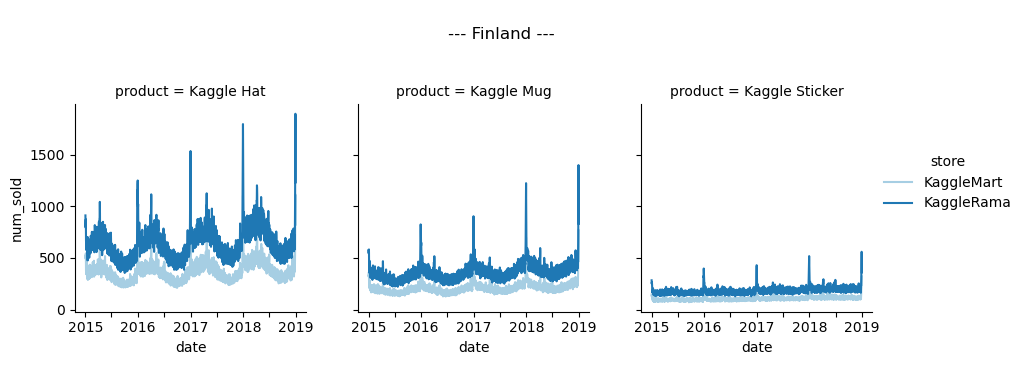

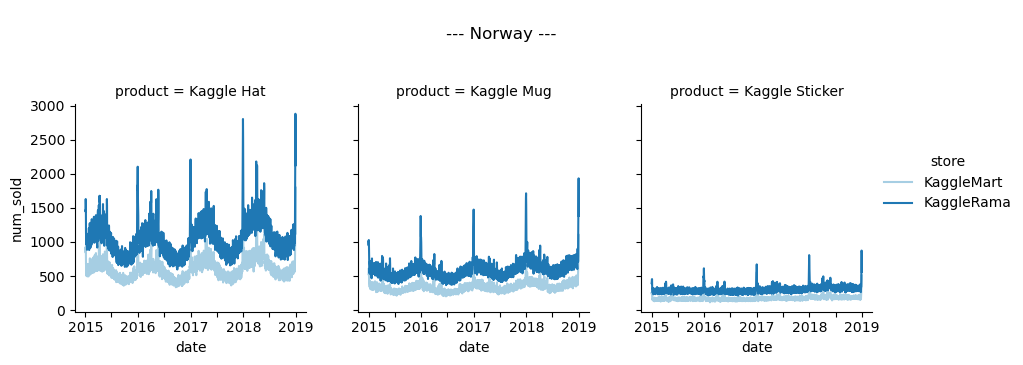

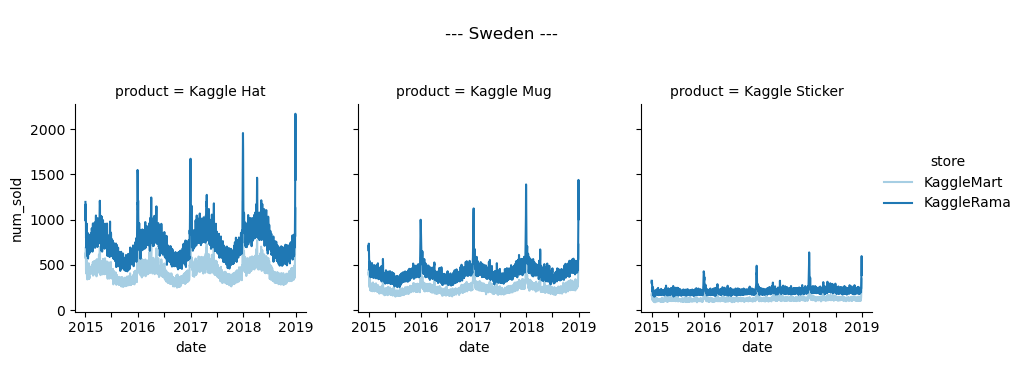

In [6]:
# create a FacetGrid with filtered data for Finland
g1 = (sns.FacetGrid(df[df['country']=='Finland'].groupby(['date','product','store']).sum()['num_sold'].reset_index(), 
                    col="product", hue ='store'));
g1.map(sns.lineplot, 'date',  'num_sold');
g1.set_xticklabels(['2015','','2016','','2017','','2018','','2019'])
g1.add_legend()
g1.fig.suptitle('\n--- Finland ---\n',y=1.2)

# create a FacetGrid with filtered data for Norway
g2 = (sns.FacetGrid(df[df['country']=='Norway'].groupby(['date','product','store']).sum()['num_sold'].reset_index(), 
                    col="product", hue ='store'));
g2.map(sns.lineplot, 'date',  'num_sold');
g2.set_xticklabels(['2015','','2016','','2017','','2018','','2019'])
g2.add_legend()
g2.fig.suptitle('\n--- Norway ---\n',y=1.2)

# create a FacetGrid with filtered data for Sweden
g3 = (sns.FacetGrid(df[df['country']=='Sweden'].groupby(['date','product','store']).sum()['num_sold'].reset_index(), 
                    col="product", hue ='store'));
g3.map(sns.lineplot, 'date',  'num_sold');
g3.set_xticklabels(['2015','','2016','','2017','','2018','','2019'])
g3.add_legend()
g3.fig.suptitle('\n--- Sweden ---\n',y=1.2);


# 2.2. Effect of the Day of the Week and Month on Sales



In [7]:
df['day_of_week'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

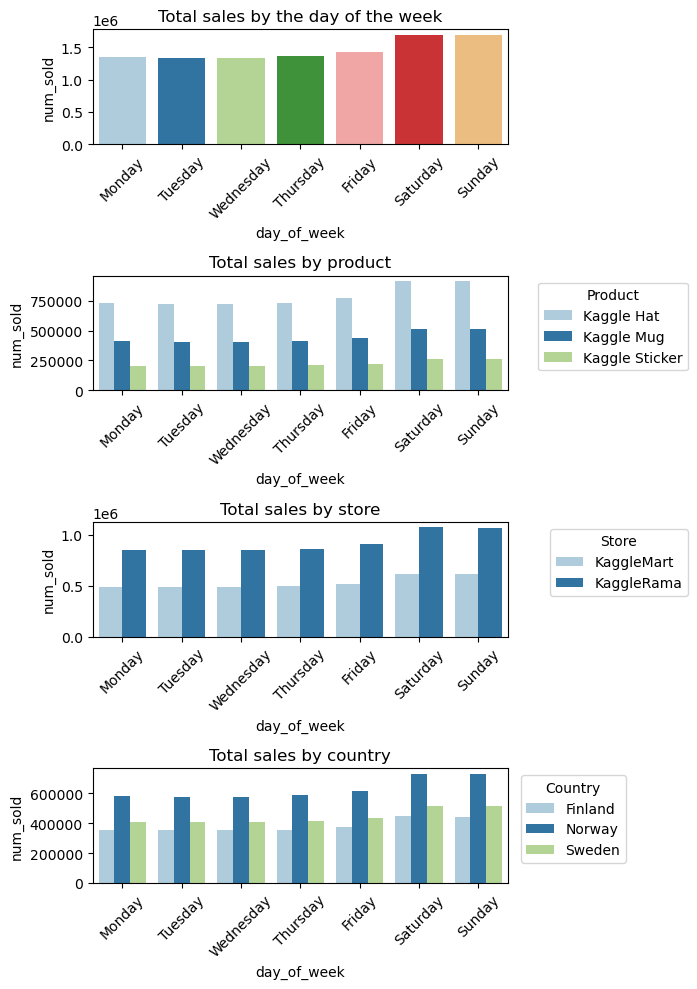

In [8]:
# Total sales by the day of the week
day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


fig, axes = plt.subplots(4, 1, figsize=(8,10));

sns.barplot(ax=axes[0], data =df.groupby(['day_of_week']).sum()['num_sold'].reset_index(), 
            x='day_of_week',y='num_sold',order=day);

sns.barplot(ax=axes[1],data=df.groupby(['day_of_week','product']).sum()['num_sold'].reset_index(), 
            x='day_of_week',y='num_sold',hue='product',order=day);

sns.barplot(ax=axes[2],data=df.groupby(['day_of_week','store']).sum()['num_sold'].reset_index(), 
            x='day_of_week',y='num_sold',hue='store',order=day);

sns.barplot(ax=axes[3],data=df.groupby(['day_of_week','country']).sum()['num_sold'].reset_index(), 
            x='day_of_week',y='num_sold',hue='country',order=day);

axes[0].set(title='Total sales by the day of the week')
axes[1].set(title='Total sales by product')
axes[2].set(title='Total sales by store')
axes[3].set(title='Total sales by country')

axes[1].legend(title='Product',loc='upper right',bbox_to_anchor=(1.45, 1));
axes[2].legend(title='Store',loc='upper right',bbox_to_anchor=(1.45, 1));
axes[3].legend(title='Country',loc='upper right',bbox_to_anchor=(1.3, 1));



axes[0].tick_params('x', labelrotation=45)
axes[1].tick_params('x', labelrotation=45)
axes[2].tick_params('x', labelrotation=45)
axes[3].tick_params('x', labelrotation=45)

fig.tight_layout()

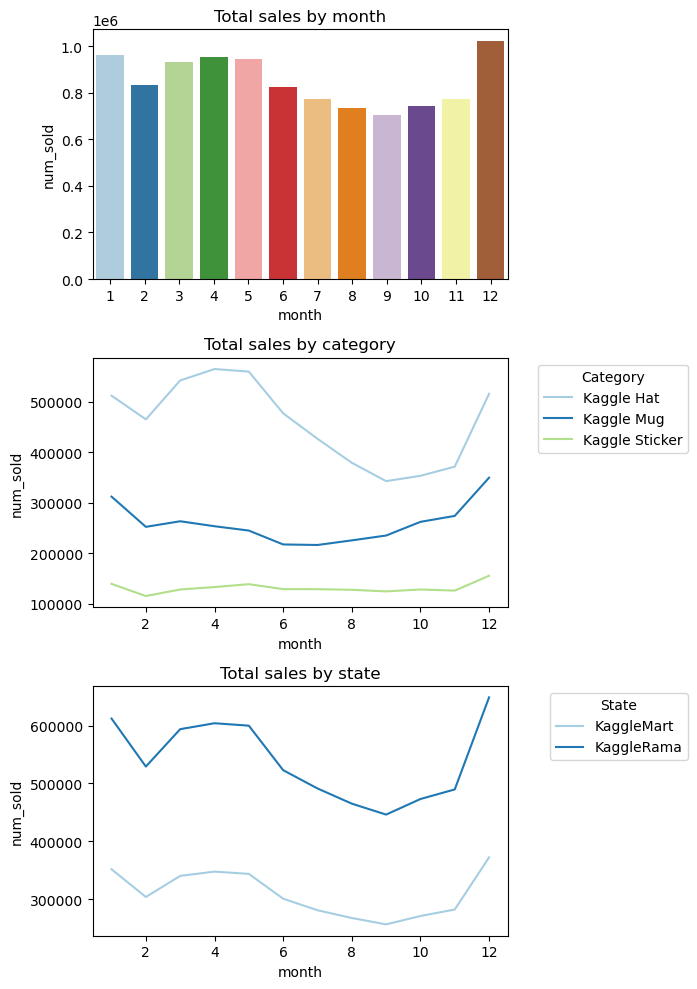

In [9]:
# Total sales by month

fig, axes = plt.subplots(3, 1, figsize=(8,10));

sns.barplot(ax=axes[0], data =df.groupby(['month']).sum()['num_sold'].reset_index(), 
            x='month',y='num_sold');

sns.lineplot(ax=axes[1],data=df.groupby(['month','product']).sum()['num_sold'].reset_index(),
            x='month',y='num_sold',hue='product');

sns.lineplot(ax=axes[2],data=df.groupby(['month','store']).sum()['num_sold'].reset_index(),
            x='month',y='num_sold',hue='store');

axes[0].set(title='Total sales by month')
axes[1].set(title='Total sales by category')
axes[2].set(title='Total sales by state')
axes[1].legend(title='Category',loc='upper right',bbox_to_anchor=(1.45, 1));

axes[2].legend(title='State',loc='upper right',bbox_to_anchor=(1.45, 1))

fig.tight_layout()

# 3. Time Series Decompostion and Sationarity

## 3.1. Decompostion

In [3]:
# pivot the DataFrame 
df_pivot = df.pivot(index=['country','store','product'], columns='date', values='num_sold').T

# select a specific subset of the pivoted DataFrame
df1 = df_pivot['Norway','KaggleMart','Kaggle Hat']

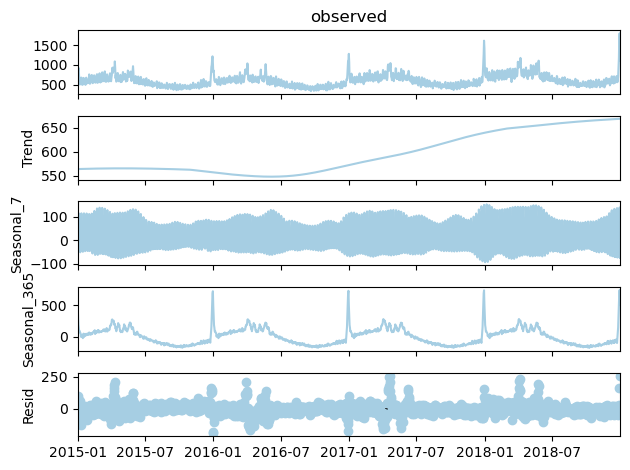

In [11]:
# MSTL decompostion
mstl = MSTL(
    endog=df1,  # Y values
    periods=(7,365),  # The periodicity of the seasonal component
    stl_kwargs={"seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
               }
)

res = mstl.fit()
ax = res.plot()


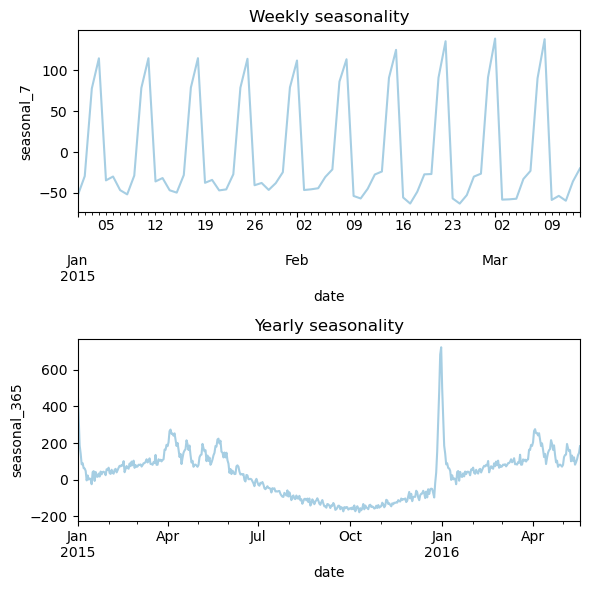

In [12]:
fig, ax = plt.subplots(nrows=2, figsize=[6,6])
res.seasonal["seasonal_7"].iloc[:24*3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_7")
ax[0].set_title("Weekly seasonality")

res.seasonal["seasonal_365"].iloc[:24*7*3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_365")
ax[1].set_title("Yearly seasonality")

plt.tight_layout()

## 3.2. Stationarity 

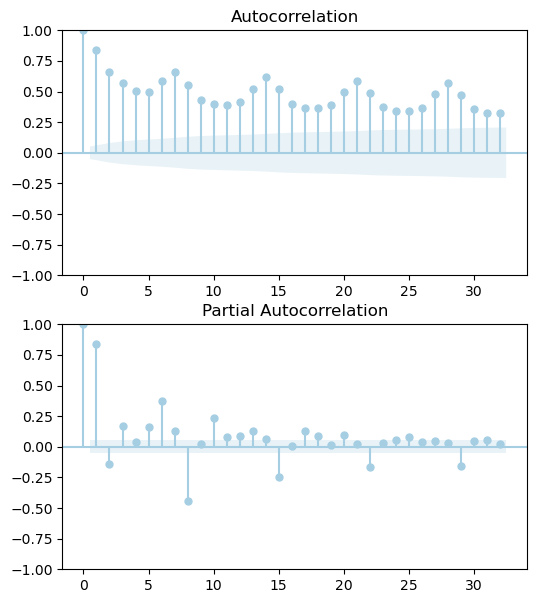

In [13]:
fig, ax = plt.subplots(nrows=2, figsize=[6,7])
plot_acf(df1,ax=ax[0]);
plot_pacf(df1,ax=ax[1]);

In [14]:
ADF_result = adfuller(df1)
print(f'ADF Statistic: {ADF_result[0]:.4f}')
print(f'p-value: {ADF_result[1]:4f}')

ADF Statistic: -2.5091
p-value: 0.113273


In [15]:
diff_df1 = np.diff(df1, n=1)
ADF_result = adfuller(diff_df1)
print(f'ADF Statistic: {ADF_result[0]:.4f}')
print(f'p-value: {ADF_result[1]:4f}')

ADF Statistic: -10.5205
p-value: 0.000000


# 4. Baseline Prediction

## 4.1. Naive Seasonal Forecast

In [16]:
x_train, x_test = temporal_train_test_split(df1, test_size=100)

In [26]:
naive_pred = df1[-465:-365]
shifted_index = naive_pred.index + pd.DateOffset(years=1)
naive_pred.index=shifted_index

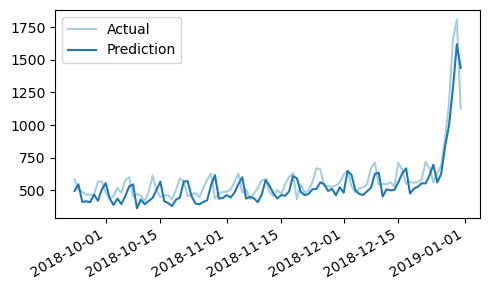

In [18]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x_test, ls='-', label='Actual')
ax.plot(naive_pred, ls='-', label='Prediction')
ax.legend(loc='best')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [19]:
print(f'MAPE: {mean_absolute_percentage_error(x_test, naive_pred)}')

MAPE: 0.13181622672652346


# 5. Classical Apporach

## 5.1. Time Series Train-Test Split

## 5.2. BATS 

In [20]:
from sktime.forecasting.bats import BATS
import time

start_time= time.time()

forecaster = BATS(  
    use_box_cox=True,
    use_trend=False,
    use_damped_trend=False,
    sp=[7,365],
    use_arma_errors=False,
    n_jobs=1)
forecaster.fit(x_train)

end_time= time.time()

run_time=end_time-start_time
print(run_time)

pred_BATS = forecaster.predict(fh=np.arange(1, 101)) 

220.2822539806366


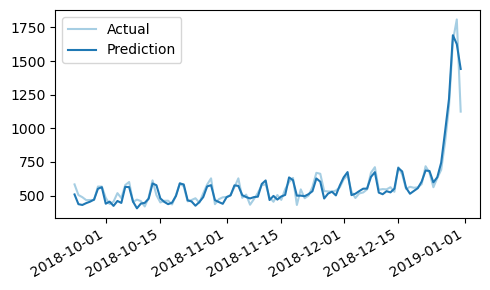

In [21]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x_test, ls='-', label='Actual')
ax.plot(pred_BATS, ls='-', label='Prediction')
ax.legend(loc='best')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


In [22]:
print(f'MAPE: {mean_absolute_percentage_error(x_test, pred_BATS)}')

MAPE: 0.05390919595745947


## 5.3. ARIMA

In [23]:
arima_model = auto_arima(df1, seasonal=True, trace = True)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16991.106, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17241.614, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17243.104, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17242.548, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17239.618, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16990.404, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17055.229, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17076.900, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=16991.463, Time=0.41 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=16992.142, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16991.978, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=16988.472, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=17053.302, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1461
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -8490.236
Date:                Thu, 15 Jun 2023   AIC                          16988.472
Time:                        11:16:01   BIC                          17009.617
Sample:                    01-01-2015   HQIC                         16996.360
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4424      0.038     11.773      0.000       0.369       0.516
ma.L1         -0.5374      0.042    -12.949      0.000      -0.619      -0.456
ma.L2         -0.3440      0.028    -12.079      0.000      -0.400      -0.288
sigma2      6581.9296    163.000     40.380      0.000    6262.454    6901.405
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1447.85
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
mod = ARIMA(df1, order=(1, 1, 2))
res = mod.fit()
print(res.summary())
results = mod.fit()

# Get prediction for test set
start = len(x_train)
end = len(x_train) + len(x_test) - 1
# type typ : levels - Predict original endogenous variables
# linear : Linear prediction
prediction = res.predict(start, end, 
                         typ='linear').rename('Prediction')

                                         SARIMAX Results                                          
Dep. Variable:     ('Norway', 'KaggleMart', 'Kaggle Hat')   No. Observations:                 1461
Model:                                     ARIMA(1, 1, 2)   Log Likelihood               -8490.236
Date:                                    Thu, 15 Jun 2023   AIC                          16988.472
Time:                                            11:17:03   BIC                          17009.617
Sample:                                        01-01-2015   HQIC                         16996.360
                                             - 12-31-2018                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4424      0.038     11.773      0

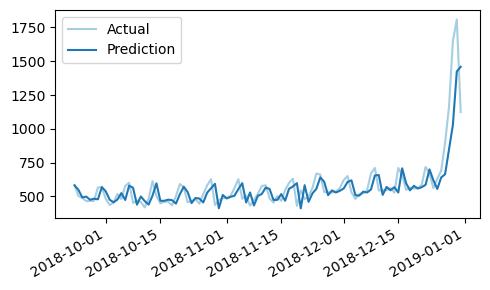

In [28]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x_test, ls='-', label='Actual')
ax.plot(prediction, ls='-', label='Prediction')
ax.legend(loc='best')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [29]:
print(f'MAPE: {mean_absolute_percentage_error(x_test, prediction)}')


MAPE: 0.10324166147364766


# 6. Prophet

## 6.1. Building a simple model in Prophet

In [4]:
df_prophet = df1.reset_index().rename(columns={'date':'ds','Norway':'y'})
df_prophet.columns= df_prophet.columns.droplevel([1,2])

df_prophet

,ds,y
0,2015-01-01,906
1,2015-01-02,845
2,2015-01-03,930
3,2015-01-04,889
4,2015-01-05,671
...,...,...
1456,2018-12-27,898
1457,2018-12-28,1162
1458,2018-12-29,1650
1459,2018-12-30,1809


In [5]:
x_train, x_test = temporal_train_test_split(df_prophet, test_size=100)

In [93]:
my_model = Prophet(yearly_seasonality=True,
                     weekly_seasonality=True,
                     daily_seasonality=False)
my_model.fit(x_train)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [94]:
future_dates = my_model.make_future_dataframe(periods=100)

In [95]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-01,704.261596,610.632655,797.407150
1,2015-01-02,730.358845,644.857324,829.456444
2,2015-01-03,834.320269,735.740984,926.666288
3,2015-01-04,827.007800,731.507467,912.743540
4,2015-01-05,678.431324,587.781695,766.497524


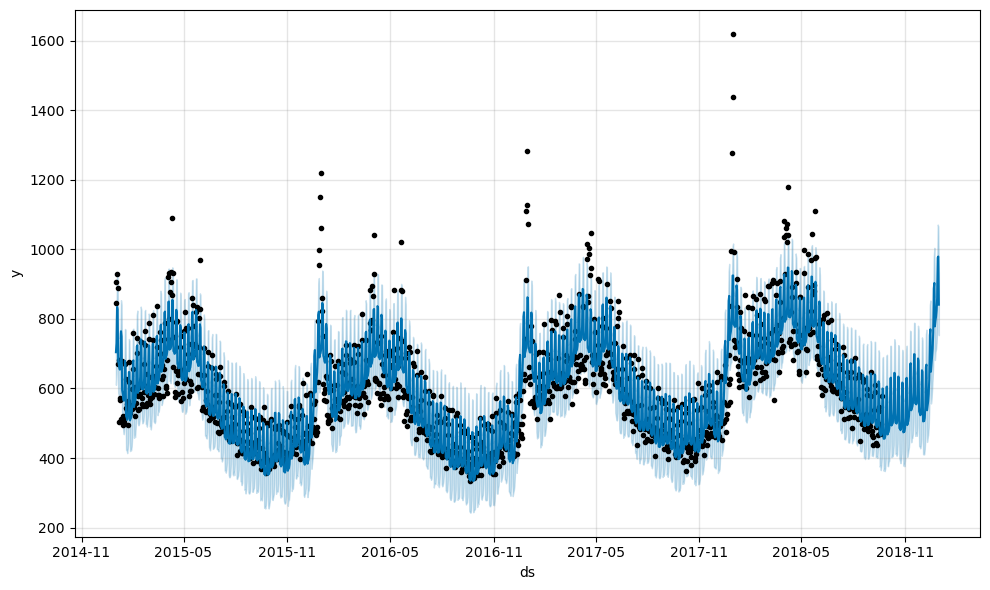

In [96]:
my_model.plot(forecast, uncertainty=True);

In [97]:
mean_absolute_percentage_error(x_test['y'], forecast['yhat'][:100])

0.2663646910169985

## 6.2. Adding Holidays

In [135]:
my_model_h = Prophet(yearly_seasonality=True,
                     weekly_seasonality=True,
                     daily_seasonality=False,
                     seasonality_mode='additive')
my_model_h.add_country_holidays(country_name='Norway')
my_model_h.fit(x_train)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [136]:
my_model_h.train_holiday_names

0         Første nyttårsdag
1           Arbeidernes dag
2              Grunnlovsdag
3            Første juledag
4             Andre juledag
5              Skjærtorsdag
6                Langfredag
7           Første påskedag
8            Andre påskedag
9     Kristi himmelfartsdag
10          Første pinsedag
11           Andre pinsedag
dtype: object

In [137]:
future_h = my_model_h.make_future_dataframe(periods=100)

In [138]:
forecast_h = my_model_h.predict(future_h)

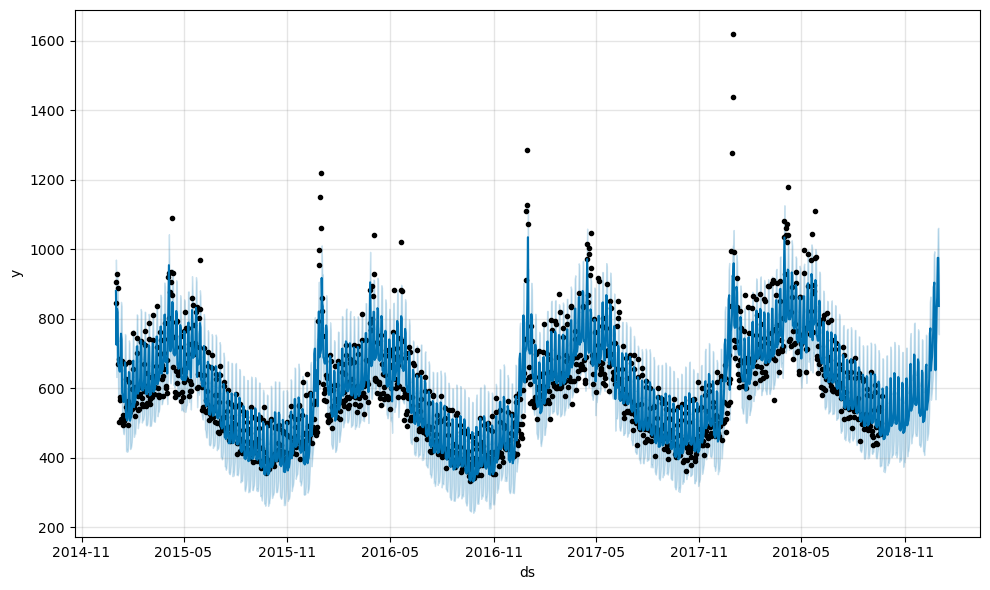

In [139]:
my_model_h.plot(forecast_h, uncertainty=True);

In [140]:
mean_absolute_percentage_error(x_test['y'], forecast_h['yhat'][:100])

0.2648758164658593